Dependency links:
- [rdflib](https://github.com/RDFLib/rdflib)
- [IMDbPY](https://github.com/alberanid/imdbpy)
- [pandas](http://pandas.pydata.org/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://www.numpy.org/)
- [unidecode](https://pypi.python.org/pypi/Unidecode)

# Selecting Film Data out of All DBTropes Data

**TODO: need to make this session into a makefile.**

DBTropes Data can be downloaded [here](http://dbtropes.org/static/dbtropes.zip). Unzipped file is (re?)named as **dbtropes.nt**.

The film data selection step should be done from the command line (too much pressure on Jupyter notebook), using the script *extract_film_data.py*:

```python

# Extracting all film type data
# Subject format: http://dbtropes.org/resource/Film/[Film Title]

import re

def main():
    film_data = open('film_data.nt', 'w')
    with open('dbtropes.nt') as rawfile:
        for line in rawfile:
            if re.match("<http://dbtropes.org/resource/Film/", line):
                film_data.write(line)
        film_data.close()

if __name__ == "__main__":
    main()
    
```

# Parsing the Film Data Set

The result of data parsing is pickeled. Start from the pickle or SQL database, see next session.

In [ ]:
# # This step takes a while. Alternative: load film_trope_dict.pkl, or use tv_tropes.db.

# from __future__ import print_function
# import rdflib

# g = rdflib.Graph()
# g.parse("film_data.nt", format="nt")

# len(g)

In [ ]:
# import re

# film_trope_dict = {}


# for t_sub, t_obj in g.subject_objects(predicate=rdflib.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')):
#     title = ''
#     trope = ''
#     try:
#         title = re.match('http://dbtropes.org/resource/Film/([^/]*)', t_sub).groups()[0]
#         trope = re.match('http://dbtropes.org/resource/Main/([^/]*)', t_obj).groups()[0]
#         if title in film_trope_dict:
#             film_trope_dict[title].append(trope)
#         else:
#             film_trope_dict[title] = [trope]
#     except Exception:
#         pass


# Preparing the Database for Downstream Analysis

## Trope Appearance Database

In [1]:
from __future__ import print_function # Because the code was moved from Python 3 to 2
import re

import pickle
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [ ]:
## write python dict to film_trope_dict.pkl

# output = open('film_trope_dict_python2.pkl', 'wb')
# pickle.dump(film_trope_dict, output, protocol=2) # default protocol is 3 in Python 3, not supported in Python 2
# output.close()

In [2]:
# read python dict back from the file
pkl_file = open('film_trope_dict_python2.pkl', 'rb')
film_trope_dict = pickle.load(pkl_file)
pkl_file.close()

In [3]:
def read_dict_to_df(input_dict):
    '''Take a dict of {title : [list of tropes in this title], 
       return a DataFrame of all film-trope pairs with an arbituary index.
       Each row of the DataFrame: autoincremented index, name of title, name of trope.'''
    df = pd.DataFrame.from_dict(input_dict, orient ="index").sort_index().stack().reset_index(level=1, drop=True).reset_index()    
    df.columns = ['title', 'trope']
    return df

# This database is the foundation of all analysis.
film_trope_df = read_dict_to_df(film_trope_dict)
film_trope_df.head()

,title,trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder
1,ABeautifulMind,HollywoodNerd
2,ABeautifulMind,TheBigBoard
3,ABeautifulMind,MadMathematician
4,ABeautifulMind,EEqualsMCHammer


In [4]:
# Some string manipulation helper functions

#import unidecode
def strip_lowercase(text):
    '''Strip spaces, capitalization, punctuation and accents from string, esp. movie titles.'''
    # text = unidecode.unidecode(text) # dependency: unidecode
    return re.sub(r'[^\w]', '', text).lower()

def add_space(text):
    '''Add spaces between captalized words, for better display of trope and movie names in the output.
       Spaces should be added just before the strings need to be outputted.'''
    return re.sub(r"\B([A-Z]+)", r" \1", text)

In [5]:
pd.options.mode.chained_assignment = None # supress pd SettingWithCopyWarning
film_trope_df['stripped_title'] = film_trope_df['title'].map(strip_lowercase, na_action='ignore')
film_trope_df['stripped_trope'] = film_trope_df['trope'].map(strip_lowercase, na_action='ignore')
film_trope_df.head()

,title,trope,stripped_title,stripped_trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder,abeautifulmind,sciencerelatedmemeticdisorder
1,ABeautifulMind,HollywoodNerd,abeautifulmind,hollywoodnerd
2,ABeautifulMind,TheBigBoard,abeautifulmind,thebigboard
3,ABeautifulMind,MadMathematician,abeautifulmind,madmathematician
4,ABeautifulMind,EEqualsMCHammer,abeautifulmind,eequalsmchammer


In [6]:
# # Make a SQL table of all title-trope pairs. Table name: 'title_trope'

# import sqlite3
# conn = sqlite3.connect('tv_tropes.db')
# film_trope_df.to_sql('title_trope', conn, if_exists='fail', index=False, index_label=None, chunksize=None)
# conn.close()

In [7]:
# Read SQL table and try out some queries

conn = sqlite3.connect('tv_tropes.db')
# cur = conn.cursor()  # Do not need cursor with pd.read_sql_query

# query = '''SELECT title, trope FROM title_trope
#            WHERE title = "TheMatrix"
#            LIMIT 10;'''

query = 'SELECT * FROM title_trope LIMIT 10'
toy_df = pd.read_sql_query(query, conn)

# Always close Connection and Cursor objects that are open when done.
# This prevents the SQLite database from being locked, which may lead to update failure and errors.
conn.close()

toy_df

,title,trope,stripped_title,stripped_trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder,abeautifulmind,sciencerelatedmemeticdisorder
1,ABeautifulMind,HollywoodNerd,abeautifulmind,hollywoodnerd
2,ABeautifulMind,TheBigBoard,abeautifulmind,thebigboard
3,ABeautifulMind,MadMathematician,abeautifulmind,madmathematician
4,ABeautifulMind,EEqualsMCHammer,abeautifulmind,eequalsmchammer
5,ABeautifulMind,TheReveal,abeautifulmind,thereveal
6,ABeautifulMind,Hallucinations,abeautifulmind,hallucinations
7,ABeautifulMind,GoodWithNumbers,abeautifulmind,goodwithnumbers
8,ABeautifulMind,TheLoinsSleepTonight,abeautifulmind,theloinssleeptonight
9,ABeautifulMind,ShoutOut,abeautifulmind,shoutout


# Movie Info Database

In [114]:
def run_query(query, sql_db='tv_tropes.db', index_col=None, coerce_float=True,
              params=None, parse_dates=None, chunksize=None):
    '''Takes a SQL query(a string) and a database (a string of 'database_name.db') in which query 
       should be performed, run the query and return the query result as a pandas DataFrame.
       Can use the same args as pd.read_sql_query().'''
    
    if not isinstance(query, basestring):
        raise TypeError('query must be a string')
    conn = sqlite3.connect(sql_db)
    df = pd.read_sql_query(query, conn, index_col=index_col, coerce_float=coerce_float, 
                           params=params, parse_dates=parse_dates, chunksize=chunksize)
    conn.close
    return df

In [12]:
# Extract omdb table from bokeh sample database movies.db

query = '''SELECT * FROM omdb;'''
omdb_df = run_query(query, 'movies.db')
omdb_df.head(3)

,ID,imdbID,Title,Year,Rating,Runtime,Genre,Released,Director,Writer,Cast,Metacritic,imdbRating,imdbVotes,Language,Country,Awards,lastUpdated,Oscars
0,4972,tt0004972,The Birth of a Nation,1915,Not Rated,165.0,"Drama, History, Romance",1915-03-03,D.W. Griffith,"Thomas F. Dixon Jr. (adapted from his novel: ""...","Lillian Gish, Mae Marsh, Henry B. Walthall, Mi...",NaN,6.9,13793.0,None,USA,1 win.,2014-03-31 02:13:23.440000000,0
1,6206,tt0006206,Les vampires,1915,Not Rated,399.0,"Action, Adventure, Crime",1915-11-13,Louis Feuillade,Louis Feuillade,"Musidora, Édouard Mathé, Marcel Lévesque, Jean...",NaN,6.6,2502.0,French,France,1 nomination.,2014-03-07 00:05:37.133000000,0
2,6864,tt0006864,Intolerance: Love's Struggle Throughout the Ages,1916,Not Rated,197.0,"Drama, History",1916-09-05,D.W. Griffith,"D.W. Griffith (scenario), Anita Loos (titles)","Lillian Gish, Spottiswoode Aitken, Mary Alden,...",NaN,8.0,8673.0,None,USA,1 win.,2014-03-27 01:05:04.920000000,0


In [13]:
omdb_df['stripped_title'] = omdb_df['Title'].map(strip_lowercase, na_action='ignore')
omdb_df.head(3)

,ID,imdbID,Title,Year,Rating,Runtime,Genre,Released,Director,Writer,Cast,Metacritic,imdbRating,imdbVotes,Language,Country,Awards,lastUpdated,Oscars,stripped_title
0,4972,tt0004972,The Birth of a Nation,1915,Not Rated,165.0,"Drama, History, Romance",1915-03-03,D.W. Griffith,"Thomas F. Dixon Jr. (adapted from his novel: ""...","Lillian Gish, Mae Marsh, Henry B. Walthall, Mi...",NaN,6.9,13793.0,None,USA,1 win.,2014-03-31 02:13:23.440000000,0,thebirthofanation
1,6206,tt0006206,Les vampires,1915,Not Rated,399.0,"Action, Adventure, Crime",1915-11-13,Louis Feuillade,Louis Feuillade,"Musidora, Édouard Mathé, Marcel Lévesque, Jean...",NaN,6.6,2502.0,French,France,1 nomination.,2014-03-07 00:05:37.133000000,0,lesvampires
2,6864,tt0006864,Intolerance: Love's Struggle Throughout the Ages,1916,Not Rated,197.0,"Drama, History",1916-09-05,D.W. Griffith,"D.W. Griffith (scenario), Anita Loos (titles)","Lillian Gish, Spottiswoode Aitken, Mary Alden,...",NaN,8.0,8673.0,None,USA,1 win.,2014-03-27 01:05:04.920000000,0,intolerancelovesstrugglethroughouttheages


In [30]:
# # Make a SQL table of omdb movie info in tv_tropes.db. Table name: 'omdb'

# conn = sqlite3.connect('tv_tropes.db')
# omdb_df.to_sql('omdb', conn, if_exists='fail', index=False, index_label=None, chunksize=None)
# conn.close()

In [169]:
# Getting a list of all possible genres
# Caution: this list has an u'Adult' genre

# def parse_genres(genres):
#     '''Take a string of genres separated by ', ', return a list of genres'''
#     regex = re.compile(r'([\w-]+)(?:$|, )')
#     return re.findall(regex, genres)

def split_str(input_str):
    '''Take a string with the format 'A, B, C', return a list ['A', 'B', 'C']/'''
    regex = re.compile(r'([\w-]+)(?:$|, )')
    return re.findall(regex, genres)

def get_genre_list():
    '''Return a list of all possible genres in omdb table.'''
    result = set()
    q = 'SELECT Genre FROM omdb;'
    temp_df = run_query(q, 'tv_tropes.db')
    for g in temp_df['Genre'].dropna().unique():
        result.update(re.split(', ', g))
    return list(result)

GENRE_LIST = get_genre_list()
GENRE_LIST.sort()
GENRE_LIST.remove(u'Adult')  # not going to deal with this
print(GENRE_LIST)

[u'Action', u'Adventure', u'Animation', u'Biography', u'Comedy', u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'Film-Noir', u'History', u'Horror', u'Music', u'Musical', u'Mystery', u'News', u'Romance', u'Sci-Fi', u'Short', u'Sport', u'Thriller', u'War', u'Western']


## (Now Obsolete) using IMDB 5000 Database
Originally I planned to use IMDbPy API, but it turned out to be not as straight forward as I expected. I then decided to use the [Kaggle IMDB 5000 Movie Database](https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset) instead. 

The database, a csv file **movie_metadata.csv**, comes from web scrapping. 28 column names:

"movie_title" "color" "num_critic_for_reviews" "movie_facebook_likes" "duration" "director_name" "director_facebook_likes" "actor_3_name" "actor_3_facebook_likes" "actor_2_name" "actor_2_facebook_likes" "actor_1_name" "actor_1_facebook_likes" "gross" "genres" "num_voted_users" "cast_total_facebook_likes" "facenumber_in_poster" "plot_keywords" "movie_imdb_link" "num_user_for_reviews" "language" "country" "content_rating" "budget" "title_year" "imdb_score" "aspect_ratio"

**Note: sadly, later I found this database was smaller than Bokeh movie sample database.**

In [ ]:
# imdb5000 = pd.read_csv('movie_metadata.csv', encoding='utf-8')
# imdb5000.head(10)

In [ ]:
# movie_info_df = imdb5000[['movie_title', 'genres', 'title_year', 'imdb_score', 'director_name', 
#                            'gross', 'budget', 'content_rating', 'movie_imdb_link']]
# movie_info_df.head()

In [ ]:
# # Some imdb helper functions

# def find_imdb_id(link):
#     '''Take a string of an IMDB link url, and return the IMDB ID of this movie (tt[\d]*7)'''
#     regex = re.compile(r':?title/(tt[\d]*)/\?ref')
#     return re.findall(regex, link)[0]

# def parse_genres_5000(genres):
#     '''Take a string of genres separated by |, return a list of genres'''
#     regex = re.compile(r'([\w-]+)(?:$|\|)')
#     return re.findall(regex, genres)

In [ ]:
# movie_info_df['imdb_id'] = movie_info_df['movie_imdb_link'].map(find_imdb_id, na_action='ignore')
# movie_info_df['stripped_title'] = movie_info_df['movie_title'].map(strip_lowercase, na_action='ignore')

# movie_info_df.drop('movie_imdb_link', axis=1, inplace=True)
# movie_info_df.set_index('imdb_id', inplace=True)
# movie_info_df.head()

In [ ]:
# # Make a SQL table of movie info. Table name: 'movie_info'

# conn = sqlite3.connect('tv_tropes.db')
# movie_info_df.to_sql('movie_info', conn, if_exists='fail', index=False, index_label=None, chunksize=None)
# conn.close()

In [ ]:
# # Test: read SQL table of movie info

# conn = sqlite3.connect('tv_tropes.db')

# query = 'SELECT * FROM movie_info LIMIT 3;'
# print(pd.read_sql_query(query, conn))

# # Always close Connection and Cursor objects that are open when done.
# # This prevents the SQLite database from being locked, which may lead to update failure and errors.
# conn.close()

In [ ]:
# # Join tables: film_trope, movie_info

# query = '''SELECT * FROM title_trope as t
#            JOIN movie_info as m
#            ON t.stripped_title = m.stripped_title;'''
# movie_joined = run_query(query)
# len(movie_joined['title'].unique())

# # Output: 2143 (titles sucessfully joined)
# # Bokeh sample database is able to join 3840

# (Now Obsolete) Using IMDbPY

In [ ]:
# # In case imdb is not imported correctly
# # In python CLI, import imdb, print imdb.__path__, and add to sys.path in jupyter

# import sys
# sys.path.append() # insert module path
# print(sys.path)

In [ ]:
# # The problem with IMDbPY is, it is difficult to get the movie object from the title.
# # And sometime an error of 'How did you gey here?' will occur

# from imdb import IMDb
    
# # Create the object that will be used to access the IMDb's database.
# ia = IMDb(accessSystem='http')

In [ ]:
# the_matrix = ia.get_movie('0133093')
# #print the_matrix['director']


In [ ]:
# print(the_matrix['title'], the_matrix['year'], the_matrix['genre'], the_matrix['rating'], the_matrix['top 250 rank'])

# Plotting

In [80]:
# Matplotlib style config
plt.rcParams.update(plt.rcParamsDefault) # reset
plt.style.use('seaborn-pastel')

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['font.size'] = 10
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 8
# plt.rcParams['ytick.labelsize'] = 8
# plt.rcParams['legend.fontsize'] = 10
# plt.rcParams['figure.titlesize'] = 12

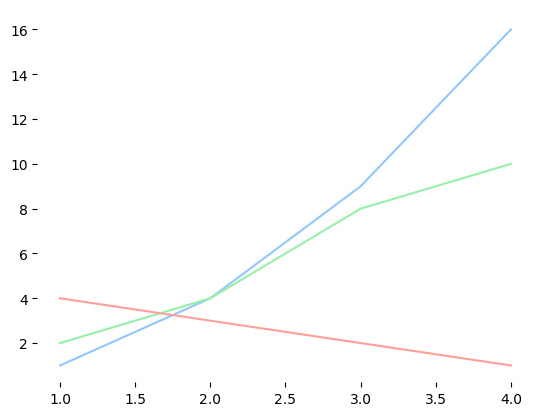

In [83]:
plt.plot([1,2,3,4], [1,4,9,16])
plt.plot([1,2,3,4], [2,4,8,10])
plt.plot([1,2,3,4], [4,3,2,1])

## Popular Tropes in Each Genre

In [184]:
# SQL dababase: tv_tropes.db
# movie-trope table: 'title_trope'
# movie info table: 'omdb'

def get_trope_counts_by_genre(genre_exp):
    '''Return a pd.DataFrame containing counts of trope appearance.
       genre_exp: a single string (eg. '%Action%') used to match genre info, omdb.Genre LIKE genre_exp.
       genre_exp can be writted to match multiple genres (in alphabetical order) in the same movie, 
       eg. '%Action%Horror%'
       Result DataFrame columns: ['trope', 'stripped_trope', 'trope_count'], sorted by trope_count (desc).
       Trope frequency will be calculated with pandas outside of this funtion.       
    '''
    
    genre_query = '''SELECT trope, stripped_trope, COUNT(stripped_trope) as trope_count
                 FROM (SELECT * FROM title_trope AS t
                       JOIN omdb AS o
                       ON t.stripped_title = o.stripped_title
                       WHERE o.Genre LIKE ?)
                 GROUP BY stripped_trope
                 ORDER BY trope_count DESC; 
                 '''
    return run_query(genre_query, params=(genre_exp,))

In [185]:
action_df = get_trope_counts_by_genre('%Action%')
action_df.head()

,trope,stripped_trope,trope_count
0,ShoutOut,shoutout,326
1,ChekhovsGun,chekhovsgun,277
2,OhCrap,ohcrap,244
3,BigBad,bigbad,217
4,LargeHam,largeham,188


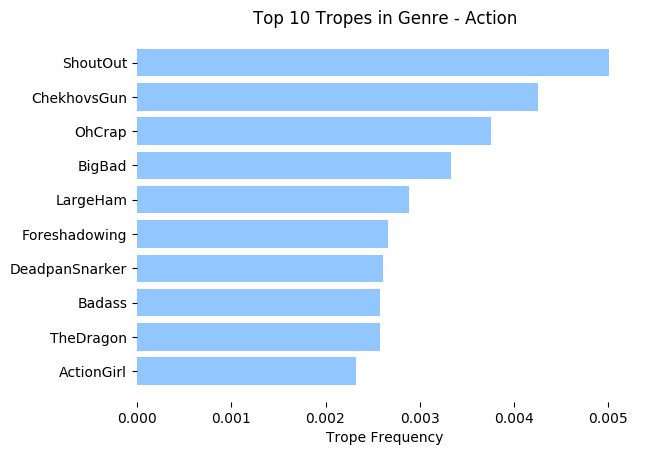

In [200]:
# Plot testing
# GENRE_LIST: a list of all possible genres

total_counts = action_df['trope_count'].sum()
action_df['trope_freq'] = action_df['trope_count'] / total_counts

fig, ax = plt.subplots()
y_pos = np.arange(10)
ax.barh(y_pos, action_df.iloc[:10]['trope_freq'])
ax.set_yticks(y_pos)
ax.set_yticklabels(action_df.iloc[:10]['trope'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Trope Frequency')
ax.set_title('Top 10 Tropes in Genre - Action')

# ---- Everything below is not reviewed yet ----

In [ ]:
# Counting the frequency of each trope

total_counts = pd.DataFrame(film_trope_df['trope'].value_counts()).reset_index()
total_counts.columns = ['trope', 'counts']

In [ ]:
# # Function to plot the distribution of the count frequency.
# # ax: where to plot
# # df: sorted DataFrame of frequencies, with an autoincrement index
# # col_data: name of the column that contains the counts
# # title, xlabel, ylabel: figure labels

# def plot_counts_dist(ax, df, col_data, title, xlabel='Trope Rank (within group)', ylabel='Trope Frequency (%)'):
#     counts_sum = df[col_data].sum()
    
    
#     ax.fill_between(x = df.index, y1 = df[col_data] / counts_sum * 100, y2 = 0, color = 'b', alpha = 0.5)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')

#     ax.set_xlim(0, len(df))
#     ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]) * len(df))

#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)


# fig, ax = plt.subplots()
# plot_counts_dist(ax, total_counts, 'counts', title = 'Distribution of Trope Frequencies \nAmong All Films in DBtropes')

In [ ]:
# Function to plot the cumulative distribution of the count frequency.
# ax: where to plot
# df: sorted DataFrame of frequencies, with an autoincrement index
# col_data: name of the column that contains the counts
# title, xlabel, ylabel: figure labels

def plot_counts_cumsum(ax, df, col_data, title, xlabel='Ranks of Tropes (within group)', ylabel='Trope Frequency (%)'):
    counts_sum = df[col_data].sum()
    cumsum_df = df[col_data].cumsum() / counts_sum * 100
    
    ax.plot(cumsum_df, color = 'b', alpha = 0.5)
    
    # add lines at 10% total trope population
    px = round(0.1 * len(cumsum_df))
    py = cumsum_df.loc[px]
    ax.plot([px, px], [0, py], 'r:', marker = 'o', alpha = 0.5)
    ax.plot([0, px], [py, py], 'r:', marker = 'o', alpha = 0.5)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlim(0, len(df))
    ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]) * len(df))
    ax.set_yticks(np.arange(0, 110, 10))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


fig, ax = plt.subplots()
plot_counts_cumsum(ax, total_counts, 'counts', title = 'Cumulative Distribution of Trope Frequencies \nAmong All Films in DBtropes')
fig.text(0.25, 0.55, 'top 10% of tropes within group')

In [ ]:
# Function to plot a 'histogram' of top frequencies
# ax: where to plot the figure
# df: sorted DataFrame of frequencies, with an autoincrement index
# col_label: name of the column that contains the trope labels 
# col_data: name of the column that contains the counts
# n: number of tropes to be shown, default 25
# title, xlabel, ylabel: figure labels
# color, alpha: bar appearance, default color = blue, alpha = 0.5
# flip_x: flip x axis, default False

def plot_counts(ax, df, col_label, col_data, title, xlabel='Counts', ylabel='Tropes', 
                color='blue', alpha=0.5, n=25, flip_x=False):
    new = df.head(n)
        
    ax.barh(new.index, new[col_data], color=color, alpha=alpha, align='center')
    ax.set_yticks(np.arange(len(new[col_label])))
    ax.set_yticklabels(new[col_label])
    ax.set_ylim(-1, len(new[col_label]))
    ax.invert_yaxis()

    if flip_x:
        ax.invert_xaxis()
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.xaxis.set_ticks_position('top')
    else:
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('top')
    
    ax.set_xlabel(xlabel)
    ax.xaxis.set_label_coords(1.18, 1.06)
    ax.set_ylabel(ylabel)
    ax.set_title(title, y = 1.08)

fig, ax = plt.subplots(figsize=(6, 7))
plot_counts(ax, total_counts, 'trope', 'counts', title='Top 25 Tropes Among All Films in DBtropes')

In [ ]:
from imdbpie import Imdb

# Initiate imdb
imdb = Imdb()
imdb = Imdb(anonymize=True) # to proxy requests

In [ ]:
top_movies = imdb.top_250()
top_250 = pd.DataFrame([movie['title'] for movie in top_movies], columns = ['imdb_title'])             

In [ ]:
# Function to strip spaces, capitalization, punctuation and accents from stitles.

import unidecode
def strip_lowercase(text):
    text = unidecode.unidecode(text) # dependency: unidecode
    return re.sub(r'[^\w]', '', text).lower()

film_trope_df['strip_title'] = film_trope_df['title'].map(strip_lowercase, na_action='ignore')
top_250['strip_title'] = top_250['imdb_title'].map(strip_lowercase, na_action='ignore')

top_250['isin_dbtrope'] = top_250['strip_title'].isin(film_trope_df['strip_title'])
film_trope_df['is_top250'] = film_trope_df['strip_title'].isin(top_250['strip_title'])

In [ ]:
len(film_trope_df[film_trope_df['is_top250'] == True]['title'].unique())
# TODO: this means there are some unfortunate mis-naming happening. Need more cleaning.
# Also some films in the top 250 do not have any trope instances, eg. Nausicaä of the Valley of the Wind

In [ ]:
# Counting tropes for movies that are in the top 250
top_counts = pd.DataFrame(film_trope_df[film_trope_df['is_top250'] == True]['trope'].value_counts()).reset_index()
top_counts.columns = ['trope', 'counts']

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5)) 
plt.setp(ax[1].get_yticklabels(), visible=True)
plot_counts_cumsum(ax[0], top_counts, 'counts', title='Distribution of Trope Frequencies \nAmong Top 250 Films') 
plot_counts_cumsum(ax[1], total_counts, 'counts', title='Distribution of Trope Frequencies \nAmong All Films in DBtropes')    

fig.text(0.18, 0.42, 'top 10% of tropes within group')
fig.text(0.6, 0.55, 'top 10% of tropes within group')
#plt.savefig('cum_distribution.png')

In [ ]:
# Summarize counts in both samples in a DataFrame combined_df
combined_df = top_counts.merge(total_counts, left_on='trope', right_on='trope', how='outer')
combined_df.fillna(0, inplace=True)
combined_df.columns = ['trope', 'top_counts', 'all_counts']
# Convert raw counts into percentages (%).
combined_df['top_counts_pct'] = combined_df['top_counts'] / top_counts['counts'].sum() * 100
combined_df['all_counts_pct'] = combined_df['all_counts'] / total_counts['counts'].sum() * 100
combined_df['top_minus_all'] = combined_df['top_counts_pct'] - combined_df['all_counts_pct']
# Find out whether all_counts_pct >, ==, or < top_250_count_pct 
# Values would be 1, 0, -1 in column 'all_VS_top, respectively
combined_df.loc[combined_df['top_minus_all'] > 0, 'top_VS_all'] = 1
combined_df.loc[combined_df['top_minus_all'] == 0, 'top_VS_all'] = 0
combined_df.loc[combined_df['top_minus_all'] < 0, 'top_VS_all'] = -1
# Generate a Series of colors to indicate 'all_VS_top' values
color_dict = {1: 'teal', 0: '#8D6868', -1: 'red'}
combined_df['colors'] = combined_df['top_VS_all'].map(color_dict)

combined_df.head()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 6)) 
plt.setp(axes[1].get_yticklabels(), visible=True)

# butterfly graph
n = 25
left_fig = plot_counts(axes[0], combined_df, 'trope', 'top_counts_pct', color=combined_df['colors'],
                       xlabel='', ylabel='',
                       title='Top 250 Films', n=n, flip_x=True)

right_fig = plot_counts(axes[1], combined_df, 'trope', 'all_counts_pct', color='#8D6868',
                        xlabel='', ylabel='',
                        title='All Films', n=n)

axes[0].tick_params(axis='y', direction='out', pad=7)
n_lim = 0.6
axes[0].set_xlim(n_lim, 0)
axes[0].set_xticks(np.arange(0, n_lim + 0.1, 0.1))
axes[1].set_xlim(0, n_lim)
axes[1].set_xticks(np.arange(0, n_lim + 0.1, 0.1))

labels = [item.get_text() for item in axes[1].get_yticklabels()]
empty_string_labels = ['']*len(labels)
axes[1].set_yticklabels(empty_string_labels)

my_suptitle=plt.suptitle('Frequency (%) of the Most "Successful" Tropes', y=1.05, fontsize=14)

plt.subplots_adjust(wspace = 1.05)

fig.savefig('most_popular_tropes_top_films.png', dpi=150, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

In [ ]:
# Scatter plot of tropes. Position of each dot / trope is its (combined_df.all_counts_pct, combined_df.top_counts_pct).
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x=combined_df['all_counts_pct'], y=combined_df['top_counts_pct'], 
          c=combined_df['colors'], alpha=0.3, linewidth=1)
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.6)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Frequency (%) Among All Films')
ax.set_ylabel('Frequency (%) Among Top 250 Films')
ax.set_title('All Tropes')

fig.text(0.7, 0.65, 'y = x', color='gray')
plt.savefig('trope_scatter.png', dpi=150, bbox_inches='tight')

In [ ]:
# Scatter plot of tropes. Position of each dot / trope is its (combined_df.all_counts_pct, combined_df.top_counts_pct).
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(combined_df[combined_df['top_counts'] > 0]['top_counts_pct'], 
           combined_df[combined_df['top_counts'] > 0]['top_minus_all'],
          c=combined_df['colors'], alpha=0.3, linewidth=1)
ax.plot(ax.get_xlim(), (0, 0), ls="--", color='gray')
ax.set_xlim(0, 0.5)
ax.set_ylim(-0.2, 0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Frequency (%) Among Top 250 Films')
ax.set_ylabel(r'$\Delta$' + ' Frequency (%)')
ax.set_title('Tropes That Appeared In Top 250 Films')
fig.text(0.7, 0.53, r'$\Delta$ = 0', color='gray')
plt.savefig('trope_delta_scatter.png', dpi=150, bbox_inches='tight')

In [ ]:
# TODO: Make a DataFrame of all movies in film_trope_dict: imdb id, title, year, genres